*Code authored by Kunal Marwaha*

To begin, I import necessary libraries.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.linalg, scipy.constants, scipy.optimize
import numpy as np
from __future__ import division
np.set_printoptions(precision=4, linewidth=120)

## Defining operators for the dimer system
We build the operators from physical parameters, as discussed in the paper.

### Hilbert Space

Parameters from [Yuen-Zhou et al., PNAS (2011)](http://arxiv.org/abs/1006.4866)

In [2]:
#system size is 2 electronic states in Hilbert space
rho = np.array([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]) #starts in ground state
n = len(rho)

In [3]:
wavenum_to_J = 1.9863e-23
debye_to_Cm = 3.33564e-30 

HD = (1+0j)*np.array([
        [0, 0, 0, 0],
        [0, 12800, 0, 0],
        [0, 0, 12800, 0],
        [0, 0, 0, 2*12800]])*wavenum_to_J #time-independent part of H, converted to Joules
Hdel = (1+0j)*np.array([
        [0, 0, 0, 0],
        [0, 81, 120, 0],
        [0, 120, -81, 0],
        [0, 0, 0, 0]])*wavenum_to_J #time-independent part of H, converted to Joules

H0 = HD + Hdel
def create_mus(mu_1,mu_2):
    out = []
    for i in range(3):
        out.append((1+0j)*np.array([
            [0      , (mu_1[i]+0j).conjugate(), (mu_2[i]+0j).conjugate(),                        0],
            [mu_1[i],                        0,                        0, (mu_2[i]+0j).conjugate()],
            [mu_2[i],                        0,                        0, (mu_1[i]+0j).conjugate()],
            [0,                        mu_2[i],                  mu_1[i],                        0]
        ])*(debye_to_Cm+0j)) #bilinear term that interacts with electric field
    return out

mu_x, mu_y, mu_z = create_mus([1, 0, 0], [2*np.cos(0.3), 2*np.sin(0.3), 0])
#typical dipole moment is sqrt(20) debye

### Liouville Space

In [4]:
#Liouvillian vectors
rho_vec = rho.ravel()
mu_vec = np.array(mu_x).ravel() #assumes final impulse is in x direction

#Liouvillian operators
def hilbert_to_liouville(H):
    n = len(H)
    return np.kron(H, np.eye(n)) - np.kron(np.eye(n), H)

hbar = scipy.constants.hbar
MD = -1j/hbar * hilbert_to_liouville(HD)
Mdel = -1j/hbar * hilbert_to_liouville(Hdel)
M0 = MD+Mdel
Mx = -1j/hbar * hilbert_to_liouville(mu_x)
My = -1j/hbar * hilbert_to_liouville(mu_y)
Mz = -1j/hbar * hilbert_to_liouville(mu_z)

### Extended Liouville Space

In [5]:
#extended Liouvillian vectors
x = np.array(list(rho_vec) + [0]*n*n*3)
C = np.array([0]*n*n*3 + list(mu_vec))

#extended Liouvillian operators
def liouville_to_extended_liouville(M):
    n2 = len(M)
    z = np.zeros((n2,n2)) #zero operator in Liouville space
    return np.concatenate(( 
        np.concatenate((z,z,z,z), axis=1),
        np.concatenate((M,z,z,z), axis=1),
        np.concatenate((z,M,z,z), axis=1),
        np.concatenate((z,z,M,z), axis=1)),axis=0)

AD = liouville_to_extended_liouville(Mdel)
Adel = liouville_to_extended_liouville(Mdel)
A = AD+Adel
Nx = liouville_to_extended_liouville(Mx)
Ny = liouville_to_extended_liouville(My)
Nz = liouville_to_extended_liouville(Mz)
N = [Nx,Ny,Nz]

### Physical Parameters

In [6]:
E_t0 = [1e7,0,0] #electric field vector at initial impulse (SI units)
E_t1 = [1e7,0,0]
E_t2 = [1e7,0,0]
dt = 0.5e-15 #in seconds
E = [E_t0, E_t1, E_t2]
t = [5e-13,5e-13,5e-13] #500fs, as an example, in seconds

In [7]:
def desperation_interaction_frame(x, time, H0, back=False):
    _temp = scipy.linalg.expm((1j/hbar)*H0*time)
    switch_matrix = np.kron(np.eye(4), np.kron(_temp, _temp))
    if back:
        switch_matrix = switch_matrix.T.conj()
    return switch_matrix.dot(x)
    
def rot_frame(x, time, HD, back=False):
    #this matrix is diagonal
    U_diag = np.exp((1j/hbar)*HD.diagonal())
    QD_diag = np.tile(np.kron(U_diag, U_diag),4)
    if back:
        QD_diag = QD_diag.conj()
    return (np.eye(len(QD_diag)) * QD_diag).dot(x)

def linear_evolution(x, time, Adel):
    op = Adel
    term = np.eye(len(op))+0j
    e_At = np.eye(len(op))+0j
    for i in range(3):
        term = term.dot(op)*time/(i+1)
        e_At += term
#     e_At = scipy.linalg.expm(Adel*time)
    return e_At.dot(x)

def bilinear_pulse(x, time, E_t, Adel, N, direc=0):
    op = Adel + E_t[direc]*N[direc]
    term = np.eye(len(op))+0j
    e_At = np.eye(len(op))+0j
    for i in range(3):
        term = term.dot(op)*time/(i+1)
        e_At += term
#     e_At = scipy.linalg.expm(op*time)
    return e_At.dot(x)

def bilinear_delta_pulse(x, time, E_t, Adel, N, direc=0):
    op = np.eye(len(x))+time*E_t[direc]*N[direc]
    return op.dot(x)
    
def bilinear_ramp_pulse(x, time, E_t, Adel, N, direc=0):
    _temp1 = bilinear_pulse(x, time/3, [0.5*i for i in E_t], Adel, N, direc=direc)
    _temp2 = bilinear_pulse(_temp1, time/3, E_t, Adel, N, direc=direc)
    return bilinear_pulse(_temp2, time/3, [0.5*i for i in E_t], Adel, N, direc=direc)

## Visualizing the state evolution 
Here, we watch the state evolve as it goes through a sample third-order spectroscopy experiment. We assume all electric field pulses are polarized in the $x-$direction.

In [8]:
def print_parts(x):
    n2 = int(len(x)/4)
    n = int(n2**0.5)
    for i in range(4):
        print("rho_"+str(i)+":")
        print(x[i*n2:(i+1)*n2].reshape((n,n)))

### Initial State

In [9]:
#initial
x0 = x.copy()
print_parts(x0)

rho_0:
[[1 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
rho_1:
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
rho_2:
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
rho_3:
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]


### Convert into Interaction Frame

In [10]:
x0i = rot_frame(x0, 0, HD)
print_parts(x0i)

rho_0:
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]]
rho_1:
[[ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]]
rho_2:
[[ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]]
rho_3:
[[ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]]


Note that $P_D(0)$ is the identity matrix, so we can ignore this step.

### Pulse 1

In [11]:
#pulse 1
# x1a = bilinear_pulse(x0i, dt, E[0], Adel, N)
# x1a = bilinear_ramp_pulse(x0i, dt, E[0], Adel, N)
x1a = bilinear_delta_pulse(x0i, dt, E[0], Adel, N)
print_parts(x1a)

rho_0:
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]]
rho_1:
[[ 0.+0.j      0.+0.0002j  0.+0.0003j  0.+0.j    ]
 [ 0.-0.0002j  0.+0.j      0.+0.j      0.+0.j    ]
 [ 0.-0.0003j  0.+0.j      0.+0.j      0.+0.j    ]
 [ 0.+0.j      0.+0.j      0.+0.j      0.+0.j    ]]
rho_2:
[[ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]]
rho_3:
[[ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]]


In [12]:
#after pulse 1
x1b = linear_evolution(x1a, t[0], Adel) 
print_parts(x1b)

rho_0:
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]]
rho_1:
[[ 0.+0.j      0.+0.0002j  0.+0.0003j  0.+0.j    ]
 [ 0.-0.0002j  0.+0.j      0.+0.j      0.+0.j    ]
 [ 0.-0.0003j  0.+0.j      0.+0.j      0.+0.j    ]
 [ 0.+0.j      0.+0.j      0.+0.j      0.+0.j    ]]
rho_2:
[[ 0.0000+0.j -0.0046+0.j  0.0005+0.j  0.0000+0.j]
 [-0.0046+0.j  0.0000+0.j  0.0000+0.j  0.0000+0.j]
 [ 0.0005+0.j  0.0000+0.j  0.0000+0.j  0.0000+0.j]
 [ 0.0000+0.j  0.0000+0.j  0.0000+0.j  0.0000+0.j]]
rho_3:
[[ 0.+0.j      0.-0.0147j  0.-0.0281j  0.+0.j    ]
 [ 0.+0.0147j  0.+0.j      0.+0.j      0.+0.j    ]
 [ 0.+0.0281j  0.+0.j      0.+0.j      0.+0.j    ]
 [ 0.+0.j      0.+0.j      0.+0.j      0.+0.j    ]]


### Pulse 2

In [13]:
#pulse 2
# x2a = bilinear_pulse(x1b, dt, E[1], Adel, N)
# x2a = bilinear_ramp_pulse(x1b, dt, E[1], Adel, N)
x2a = bilinear_delta_pulse(x1b, dt, E[1], Adel, N)
print_parts(x2a)

rho_0:
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]]
rho_1:
[[ 0.+0.j      0.+0.0003j  0.+0.0006j  0.+0.j    ]
 [ 0.-0.0003j  0.+0.j      0.+0.j      0.+0.j    ]
 [ 0.-0.0006j  0.+0.j      0.+0.j      0.+0.j    ]
 [ 0.+0.j      0.+0.j      0.+0.j      0.+0.j    ]]
rho_2:
[[ -2.3264e-07+0.j  -4.6213e-03+0.j   5.1778e-04+0.j  -9.5579e-08+0.j]
 [ -4.6213e-03+0.j   5.0024e-08+0.j   9.5579e-08+0.j   0.0000e+00+0.j]
 [  5.1778e-04+0.j   9.5579e-08+0.j   1.8262e-07+0.j   0.0000e+00+0.j]
 [ -9.5579e-08+0.j   0.0000e+00+0.j   0.0000e+00+0.j   0.0000e+00+0.j]]
rho_3:
[[ 0. -2.6470e-23j  0. -1.4701e-02j  0. -2.8088e-02j  0. -1.3146e-06j]
 [ 0. +1.4701e-02j  0. +0.0000e+00j  0. -1.4783e-06j  0. +0.0000e+00j]
 [ 0. +2.8088e-02j  0. +1.4783e-06j  0. +0.0000e+00j  0. +0.0000e+00j]
 [ 0. +1.3146e-06j  0. +0.0000e+00j  0. +0.0000e+00j  0. +0.0000e+00j]]


In [14]:
#after pulse 2
x2b = linear_evolution(x2a, t[1], Adel) 
print_parts(x2b)

rho_0:
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]]
rho_1:
[[ 0.+0.j      0.+0.0003j  0.+0.0006j  0.+0.j    ]
 [ 0.-0.0003j  0.+0.j      0.+0.j      0.+0.j    ]
 [ 0.-0.0006j  0.+0.j      0.+0.j      0.+0.j    ]
 [ 0.+0.j      0.+0.j      0.+0.j      0.+0.j    ]]
rho_2:
[[ -2.3264e-07+0.j  -1.3864e-02+0.j   1.5533e-03+0.j  -9.5579e-08+0.j]
 [ -1.3864e-02+0.j   5.0024e-08+0.j   9.5579e-08+0.j   0.0000e+00+0.j]
 [  1.5533e-03+0.j   9.5579e-08+0.j   1.8262e-07+0.j   0.0000e+00+0.j]
 [ -9.5579e-08+0.j   0.0000e+00+0.j   0.0000e+00+0.j   0.0000e+00+0.j]]
rho_3:
[[ 0. -2.6470e-23j  0. -7.3503e-02j  0. -1.4044e-01j  0. -1.3146e-06j]
 [ 0. +7.3503e-02j  0. +0.0000e+00j  0. -4.4350e-06j  0. +0.0000e+00j]
 [ 0. +1.4044e-01j  0. +4.4350e-06j  0. +0.0000e+00j  0. +0.0000e+00j]
 [ 0. +1.3146e-06j  0. +0.0000e+00j  0. +0.0000e+00j  0. +0.0000e+00j]]


### Pulse 3

In [15]:
#pulse 3
# x3a = bilinear_pulse(x2b, dt, E[2], Adel, N)
# x3a = bilinear_ramp_pulse(x2b, dt, E[2], Adel, N)
x3a = bilinear_delta_pulse(x2b, dt, E[2], Adel, N)
print_parts(x3a)

rho_0:
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]]
rho_1:
[[ 0.+0.j      0.+0.0005j  0.+0.0009j  0.+0.j    ]
 [ 0.-0.0005j  0.+0.j      0.+0.j      0.+0.j    ]
 [ 0.-0.0009j  0.+0.j      0.+0.j      0.+0.j    ]
 [ 0.+0.j      0.+0.j      0.+0.j      0.+0.j    ]]
rho_2:
[[ -6.9793e-07+0.j  -1.3864e-02+0.j   1.5533e-03+0.j  -2.8674e-07+0.j]
 [ -1.3864e-02+0.j   1.5007e-07+0.j   2.8674e-07+0.j   0.0000e+00+0.j]
 [  1.5533e-03+0.j   2.8674e-07+0.j   5.4786e-07+0.j   0.0000e+00+0.j]
 [ -2.8674e-07+0.j   0.0000e+00+0.j   0.0000e+00+0.j   0.0000e+00+0.j]]
rho_3:
[[ 0. +7.9409e-23j  0. -7.3503e-02j  0. -1.4044e-01j  0. -5.2583e-06j]
 [ 0. +7.3503e-02j  0. +0.0000e+00j  0. -8.8700e-06j  0. +4.5348e-11j]
 [ 0. +1.4044e-01j  0. +8.8700e-06j  0. +0.0000e+00j  0. +8.6645e-11j]
 [ 0. +5.2583e-06j  0. -4.5348e-11j  0. -8.6645e-11j  0. +0.0000e+00j]]


In [16]:
#after pulse 3
x3b = linear_evolution(x3a, t[2], Adel) 
print_parts(x3b)

rho_0:
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]]
rho_1:
[[ 0.+0.j      0.+0.0005j  0.+0.0009j  0.+0.j    ]
 [ 0.-0.0005j  0.+0.j      0.+0.j      0.+0.j    ]
 [ 0.-0.0009j  0.+0.j      0.+0.j      0.+0.j    ]
 [ 0.+0.j      0.+0.j      0.+0.j      0.+0.j    ]]
rho_2:
[[ -6.9793e-07+0.j  -2.7728e-02+0.j   3.1067e-03+0.j  -2.8674e-07+0.j]
 [ -2.7728e-02+0.j   1.5007e-07+0.j   2.8674e-07+0.j   0.0000e+00+0.j]
 [  3.1067e-03+0.j   2.8674e-07+0.j   5.4786e-07+0.j   0.0000e+00+0.j]
 [ -2.8674e-07+0.j   0.0000e+00+0.j   0.0000e+00+0.j   0.0000e+00+0.j]]
rho_3:
[[ 0. +7.9409e-23j  0. -2.0581e-01j  0. -3.9323e-01j  0. -5.2583e-06j]
 [ 0. +2.0581e-01j  0. +0.0000e+00j  0. -1.7740e-05j  0. +4.5348e-11j]
 [ 0. +3.9323e-01j  0. +1.7740e-05j  0. +0.0000e+00j  0. +8.6645e-11j]
 [ 0. +5.2583e-06j  0. -4.5348e-11j  0. -8.6645e-11j  0. +0.0000e+00j]]


### Convert out of Interaction Frame

In [17]:
xout = rot_frame(x3b, t[2]+3*dt, HD, back=True)
print_parts(xout)

rho_0:
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]]
rho_1:
[[ 0.0000+0.j     -0.0002+0.0004j -0.0003+0.0008j  0.0000+0.j    ]
 [ 0.0002-0.0004j  0.0000+0.j      0.0000+0.j      0.0000+0.j    ]
 [ 0.0003-0.0008j  0.0000+0.j      0.0000+0.j      0.0000+0.j    ]
 [ 0.0000+0.j      0.0000+0.j      0.0000+0.j      0.0000+0.j    ]]
rho_2:
[[ -6.9793e-07 +0.0000e+00j  -2.5728e-02 -1.0340e-02j   2.8826e-03 +1.1585e-03j  -2.0699e-07 -1.9842e-07j]
 [ -2.5728e-02 -1.0340e-02j   1.0833e-07 +1.0385e-07j   2.0699e-07 +1.9842e-07j   0.0000e+00 +0.0000e+00j]
 [  2.8826e-03 +1.1585e-03j   2.0699e-07 +1.9842e-07j   3.9549e-07 +3.7912e-07j   0.0000e+00 +0.0000e+00j]
 [ -2.0699e-07 -1.9842e-07j   0.0000e+00 +0.0000e+00j   0.0000e+00 +0.0000e+00j   0.0000e+00 +0.0000e+00j]]
rho_3:
[[  0.0000e+00 +7.9409e-23j   7.6746e-02 -1.9096e-01j   1.4664e-01 -3.6487e-01j   3.6388e-06 -3.7959e-06j]
 [ -7.6746e-02 +1.9096e-01

### Polarization pulse

In [18]:
#polarization output
print(C.dot(xout)) #in C/m^2
print(C.dot(xout) / debye_to_Cm) #in Debye

0j
0j


## Evolution while varying $t_1, t_2, t_3$

We can discretize $t_1,t_2,t_3$ to find the output polarization data across different timescales.

In [19]:
def evolve(rho, HD, Hdel, mu_1, mu_2, E, t, dt, rot=True, ramp=False, delta=False, desp=False):
    ###########################################
    ###############from before#################
    ###########################################
    n = len(rho)
    H0 = HD + Hdel
    mu_x, mu_y, mu_z = create_mus(mu_1, mu_2)
    rho_vec = rho.ravel()
    mu_vec = np.array(mu_x).ravel() #assumes final impulse is in x direction
    hbar = scipy.constants.hbar
    MD = -1j/hbar * hilbert_to_liouville(HD)
    Mdel = -1j/hbar * hilbert_to_liouville(Hdel)
    M0 = MD+Mdel
    Mx = -1j/hbar * hilbert_to_liouville(mu_x)
    My = -1j/hbar * hilbert_to_liouville(mu_y)
    Mz = -1j/hbar * hilbert_to_liouville(mu_z)
    x0 = np.array(list(rho_vec) + [0]*n*n*3)
    C = np.array([0]*n*n*3 + list(mu_vec))
    AD = liouville_to_extended_liouville(Mdel)
    Adel = liouville_to_extended_liouville(Mdel)
    A = AD+Adel
    Nx = liouville_to_extended_liouville(Mx)
    Ny = liouville_to_extended_liouville(My)
    Nz = liouville_to_extended_liouville(Mz)
    N = [Nx,Ny,Nz]
    ###########################################
    ################new stuff##################
    ###########################################
    linear_fn = linear_evolution
    bilinear_fn = bilinear_ramp_pulse if ramp else bilinear_pulse
    if delta:
        bilinear_fn = bilinear_delta_pulse
    if rot:
        x0 = rot_frame(x0, 0, HD, back=False)
    x1a = bilinear_fn(x0, dt, E[0], Adel, N)
    x1b = linear_fn(x1a, t[0], Adel)
    x2a = bilinear_fn(x1b, dt, E[1], Adel, N)
    x2b = linear_fn(x2a, t[1], Adel)
    x3a = bilinear_fn(x2b, dt, E[2], Adel, N)
    xout = linear_fn(x3a, t[2], Adel)
    if rot:
        xout = rot_frame(xout, t[2]+3*dt, HD, back=True)
    if not desp:
        return xout
    return desperation_interaction_frame(xout, t[2]+3*dt, H0, back=True)

I check that the values match with the previous section.

In [20]:
HD = (1+0j)*np.array([
        [0, 0, 0, 0],
        [0, 12800, 0, 0],
        [0, 0, 12800, 0],
        [0, 0, 0, 2*12800]])*wavenum_to_J #time-independent part of H, converted to Joules
Hdel = (1+0j)*np.array([
        [0, 0, 0, 0],
        [0, 81, 120, 0],
        [0, 120, -81, 0],
        [0, 0, 0, 0]])*wavenum_to_J #time-independent part of H, converted to Joules
rho = np.array([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]) #starts in ground state
mu_1, mu_2 =  [1,0,0], [2*np.cos(0.3), 2*np.sin(0.3),0]

In [21]:
xout_test = evolve(rho, HD, Hdel, mu_1, mu_2, E, t, dt, rot=True, ramp=False, delta=True, desp=False)
assert C.dot(xout_test)/ debye_to_Cm == C.dot(xout)/debye_to_Cm, "Not the same!"
print('ok')

ok


In [22]:
print_parts(xout_test)

rho_0:
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]]
rho_1:
[[ 0.0000+0.j     -0.0002+0.0004j -0.0003+0.0008j  0.0000+0.j    ]
 [ 0.0002-0.0004j  0.0000+0.j      0.0000+0.j      0.0000+0.j    ]
 [ 0.0003-0.0008j  0.0000+0.j      0.0000+0.j      0.0000+0.j    ]
 [ 0.0000+0.j      0.0000+0.j      0.0000+0.j      0.0000+0.j    ]]
rho_2:
[[ -6.9793e-07 +0.0000e+00j  -2.5728e-02 -1.0340e-02j   2.8826e-03 +1.1585e-03j  -2.0699e-07 -1.9842e-07j]
 [ -2.5728e-02 -1.0340e-02j   1.0833e-07 +1.0385e-07j   2.0699e-07 +1.9842e-07j   0.0000e+00 +0.0000e+00j]
 [  2.8826e-03 +1.1585e-03j   2.0699e-07 +1.9842e-07j   3.9549e-07 +3.7912e-07j   0.0000e+00 +0.0000e+00j]
 [ -2.0699e-07 -1.9842e-07j   0.0000e+00 +0.0000e+00j   0.0000e+00 +0.0000e+00j   0.0000e+00 +0.0000e+00j]]
rho_3:
[[  0.0000e+00 +7.9409e-23j   7.6746e-02 -1.9096e-01j   1.4664e-01 -3.6487e-01j   3.6388e-06 -3.7959e-06j]
 [ -7.6746e-02 +1.9096e-01

## Plotting our results

We can plot our results, both in time-space and frequency-space.

In [23]:
def make_plots(rho, HD, Hdel, mu_1, mu_2, C, E, dt, t1=np.linspace(0,1e-12,5+1),t2=np.linspace(0,1e-12,5+1),t3=np.linspace(0,1e-12,5+1)):
    X = (0+0j)*np.ones((len(t1),len(t2),len(t3)))
    for i in range(len(t1)):
        for j in range(len(t2)):
            for k in range(len(t3)):
                X[i][j][k] = C.dot(evolve(rho, HD, Hdel, mu_1, mu_2, E, (t1[i],t2[j],t3[k]), dt, desp=False, delta=False, rot=True, ramp=False)) 
    return (t1,t2,t3), X

In [24]:
%time (t1,t2,t3), out = make_plots(rho, HD, Hdel, mu_1, mu_2, C, E, dt, \
                                   t1=np.linspace(0,1e-12,50+1), t2=np.linspace(0,1e-12,2+1), t3=np.linspace(0,1e-12,50+1))

Wall time: 55 s


Checking that numbers are reasonable (should be about $R(V\Delta t)^3 = R(10^7 10^{-13})^3 = 10^{-18}R$. Since $R\thicksim 10$ in the Python package $qspectra$, we should see numbers of magnitude $\thicksim 10^{-17}$.

In [25]:
print(out.max()/debye_to_Cm)
print(out.min()/debye_to_Cm)

(2.62561769317e-16+2.10049415453e-16j)
(-1.83793238522e-16-1.05024707727e-16j)


### Time-domain

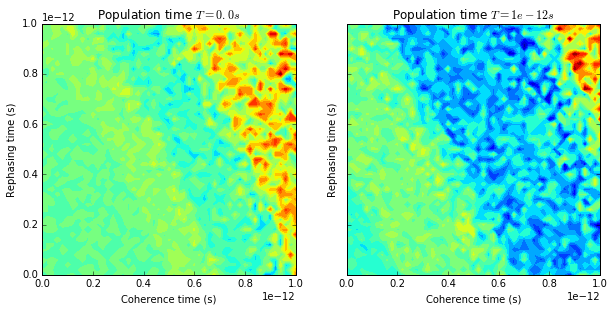

In [26]:
plt.figure(figsize=(10,4.5))
plt.subplot(121)
plt.title('Population time $T=%ss$' % t2[0])
plt.contourf(t1, t3, out[:,0,:].real, 20, vmax=out[:,0,:].real.max());
plt.xlabel('Coherence time (s)')
plt.ylabel('Rephasing time (s)')
plt.subplot(122)
plt.title('Population time $T=%ss$' % t2[-1])
plt.contourf(t1, t3, out[:,-1,:].real, 20, vmax=out[:,-1,:].real.max());
plt.xlabel('Coherence time (s)')
plt.ylabel('Rephasing time (s)')
plt.gca().get_yaxis().set_ticklabels([]);

### Conversion to frequency space

In [27]:
from qspectra import fourier_transform, CM_FS

In [28]:
f1, X_ftt = fourier_transform(t1*1e15, out/debye_to_Cm , 0, sign=-1, rw_freq=12800, unit_convert=CM_FS)
f3, X_ftf = fourier_transform(t3*1e15, X_ftt, 2, rw_freq=12800, unit_convert=CM_FS)

In [29]:
X_ftf.real.max()

2.0447647047595924e-11

This is what a flat signal in time looks like.

In [30]:
# noise = 2e-46*np.ones(out.shape)
# _, noise_ftt = fourier_transform(t1*1e15, noise/debye_to_Cm, 0, sign=-1, rw_freq=12800, unit_convert=CM_FS)
# _, noise_ftf = fourier_transform(t3*1e15, noise_ftt, 2, rw_freq=12800, unit_convert=CM_FS)

# plt.figure(figsize=(10,4.5))
# plt.subplot(121)
# plt.title('Population time $T=%s$' % t2[0])
# plt.contourf(f1, f3, noise_ftf[:,0,:].real, 30, vmax=noise_ftf[:,0,:].real.max()/3)
# plt.xlabel('Coherence frequency (cm$^{-1}$)')
# plt.ylabel('Rephasing frequency (cm$^{-1}$)')
# plt.xlim(12500, 13100)
# plt.ylim(12500, 13100)
# plt.grid(True)

# plt.subplot(122)
# plt.title('Population time $T=%s$' % t2[-1])
# plt.contourf(f1, f3, abs(noise_ftf[:,-1,:].real), 30,vmax=noise_ftf[:,-1,:].real.max()/3)
# plt.xlabel('Coherence frequency (cm$^{-1}$)')
# plt.gca().get_yaxis().set_ticklabels([]);
# plt.xlim(12500, 13100)
# plt.ylim(12500, 13100)
# plt.grid(True)

Here is the plot.

In [31]:
# X_ftf = X_ftf - noise_ftf

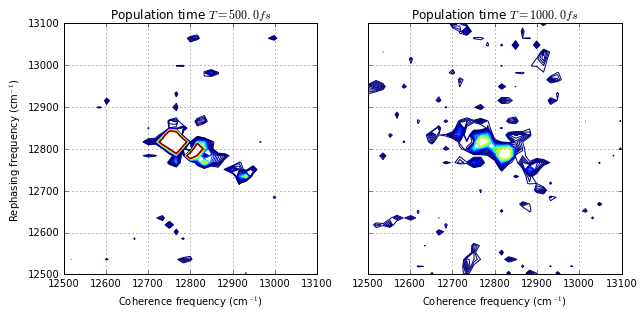

In [32]:
from matplotlib.ticker import MaxNLocator
plt.figure(figsize=(10,4.5))
plt.subplot(121)
levels = MaxNLocator(nbins=30).tick_values(X_ftf[:,1,:].real.max()/5.5, X_ftf[:,1,:].real.max()/2)
plt.title('Population time $T=%sfs$' % (t2[1]*1e15))
plt.contour(f1, f3, abs(X_ftf[:,1,:].real), 30, levels=levels, vmin=X_ftf[:,1,:].real.max()/4, vmax=X_ftf[:,1,:].real.max()/2)
plt.xlabel('Coherence frequency (cm$^{-1}$)')
plt.ylabel('Rephasing frequency (cm$^{-1}$)')
plt.xlim(12500, 13100)
plt.ylim(12500, 13100)
plt.grid(True)

plt.subplot(122)
levels = MaxNLocator(nbins=30).tick_values(X_ftf[:,1,:].real.max()/4, X_ftf[:,1,:].real.max())
plt.title('Population time $T=%sfs$' % (t2[-1]*1e15))
plt.contour(f1, f3, abs(X_ftf[:,-1,:].real), 30, levels=levels, vmin=X_ftf[:,-1,:].real.max()/4, vmax=X_ftf[:,-1,:].real.max())
plt.xlabel('Coherence frequency (cm$^{-1}$)')
plt.gca().get_yaxis().set_ticklabels([]);
plt.xlim(12500, 13100)
plt.ylim(12500, 13100)
plt.grid(True)

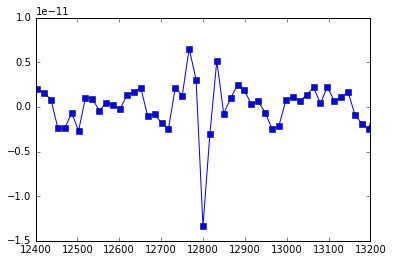

In [33]:
_temp = np.einsum('iti->ti', X_ftf)[-1]

plt.plot(f1, _temp.real, '-s');
# plt.plot(f1, np.einsum('iti->ti', noise_ftf/wavenum_to_J)[0].real, '-s');
# plt.xlabel('Diagonal frequency (cm$^{-1}$)')
plt.xlim(12400, 13200);
# plt.ylim(0,1e-19);

In [34]:
eigvals = np.linalg.eigvals(H0[1:3,1:3]/wavenum_to_J)[::-1].real
print(eigvals)
alpha, beta = np.argmin(np.abs(f1 - eigvals.reshape(-1, 1)), 1)

[ 12655.2209  12944.7791]


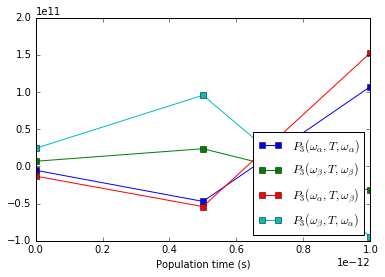

In [35]:
plt.plot(t2, X_ftf[alpha, :, alpha].real/wavenum_to_J, '-s', label=r'$P_3(\omega_\alpha, T, \omega_\alpha)$')
plt.plot(t2, X_ftf[beta, :, beta].real/wavenum_to_J, '-s', label=r'$P_3(\omega_\beta, T, \omega_\beta)$')
plt.plot(t2, X_ftf[alpha, :, beta].real/wavenum_to_J, '-s', label=r'$P_3(\omega_\alpha, T, \omega_\beta)$')
plt.plot(t2, X_ftf[beta, :, alpha].real/wavenum_to_J, '-s', label=r'$P_3(\omega_\beta, T, \omega_\alpha)$')
plt.xlabel('Population time (s)')
plt.legend(loc='lower right');

## Inversion

### Determining Convexity

Let's start by fixing $t_1,t_2,t_3$ and varying $\mu_a,\mu_b$. We can visually inspect whether this function is convex with respect to $\mu$.

In [36]:
y,z = 30,30
a = np.linspace(0, 2, y)
b = np.linspace(0, 2, z)
P3 = np.zeros((y,z))*(1+0j)
for i in range(len(a)):
    for j in range(len(b)):
        P3[i][j] = C.dot(evolve(rho, HD, Hdel, [a[i], 0, 0], [b[j], 0, 0], E, t, dt))/debye_to_Cm

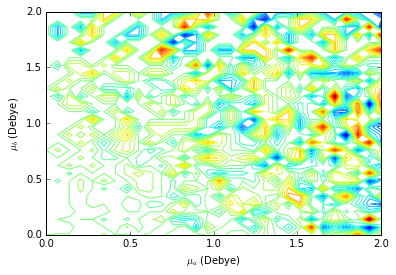

In [37]:
plt.contour(a, b, np.real(P3), 30)
plt.xlabel('$\mu_a$ (Debye)')
plt.ylabel('$\mu_b$ (Debye)')

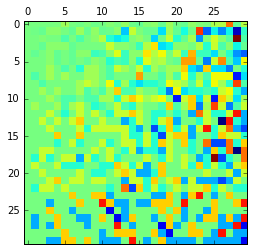

In [38]:
plt.matshow(np.real(P3))


It does not look like this function is convex, since there are numerous bumps (local extrema) as we vary $\mu_a$ and $\mu_b$.

### Gradient Descent 

We can still try to recover $\mu$ through stochastic methods, namely via gradient descent.

In [39]:
def pol_mu(mu_a, mu_b):
    E = [[1e7,0,0], [1e7,0,0], [1e7,0,0]]
    t = [1e-13,1e-13,1e-13]
    dt= 1e-15
    return C.dot(evolve(rho, HD, Hdel, mu_a, mu_b, E, t, dt, desp=True, delta=True, rot=True))/debye_to_Cm #returns magnitude

correct_mu = pol_mu( [1, 0, 0], [2*np.cos(0.3), 0, 0])
def mse_mu(inp):
    mu_a = [1, 0, 0]
    mu_b = [inp[0], 0, 0]
    return 1e18*np.linalg.norm(pol_mu(mu_a, mu_b) - correct_mu)

Notice how the function rapidly oscillates --- it will be hard to find the correct minimum.

In [40]:
2*np.cos(0.3)

1.910672978251212

In [41]:
scipy.optimize.fmin_tnc(mse_mu, [1.9065], pgtol=1e-20, xtol=1e-20, epsilon=1e-1, ftol=1e-20, approx_grad=True)

(array([ 1.9065]), 60, 4)

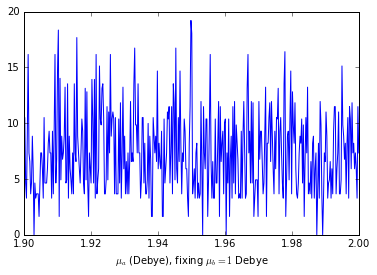

In [42]:
_x = np.linspace(1.9, 2, 400, dtype=np.double)
_y = [mse_mu([i]) for i in _x]
plt.plot(_x,_y)
plt.xlim(1.9, 2)
plt.xlabel("$\mu_a$ (Debye), fixing $\mu_b=1$ Debye")

This is frustrating. The minimum will likely not be found since the function has too many local minima.

*End of notebook*